100%|██████████| 5.16M/5.16M [00:00<00:00, 64.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/brycecf/give-me-some-credit-dataset/versions/1
Aperçu des données :
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588

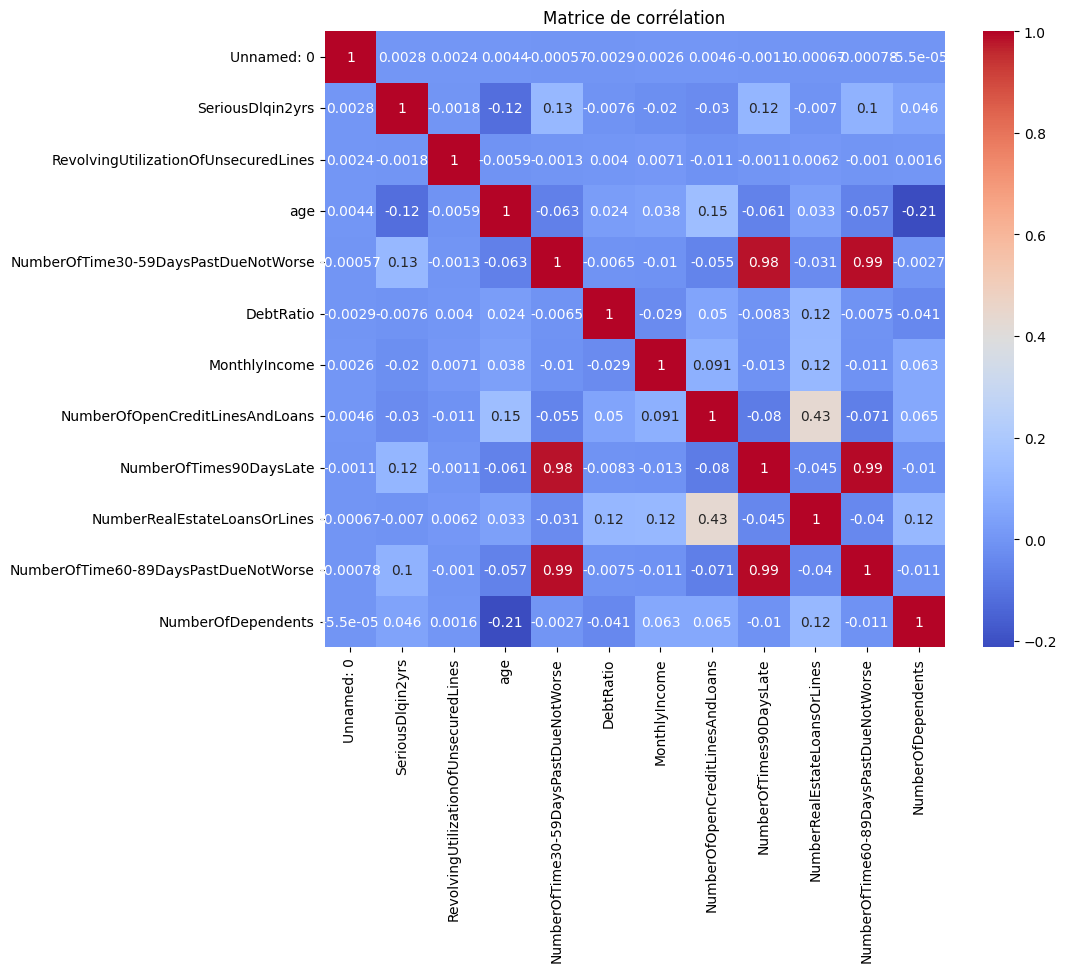

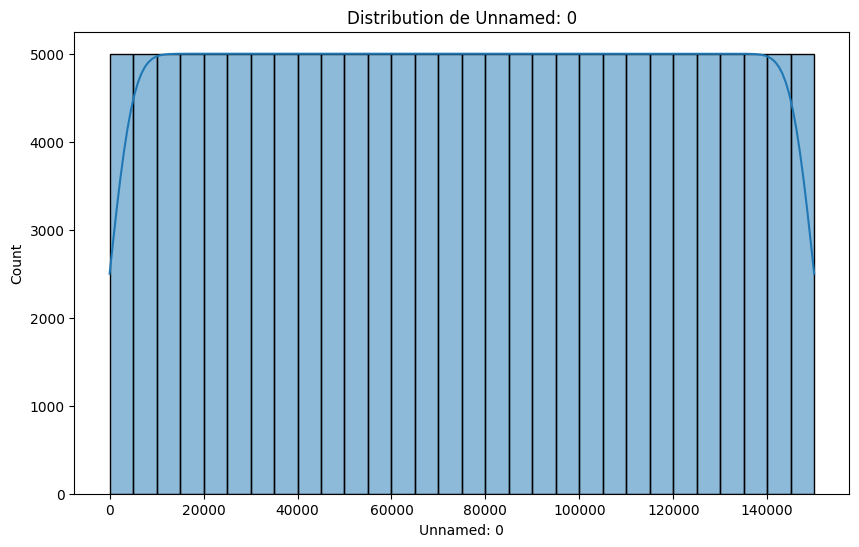

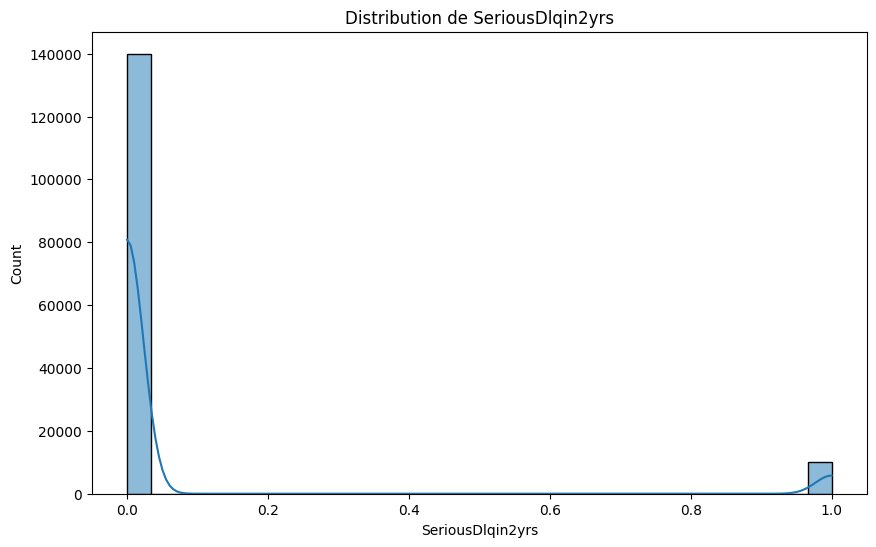

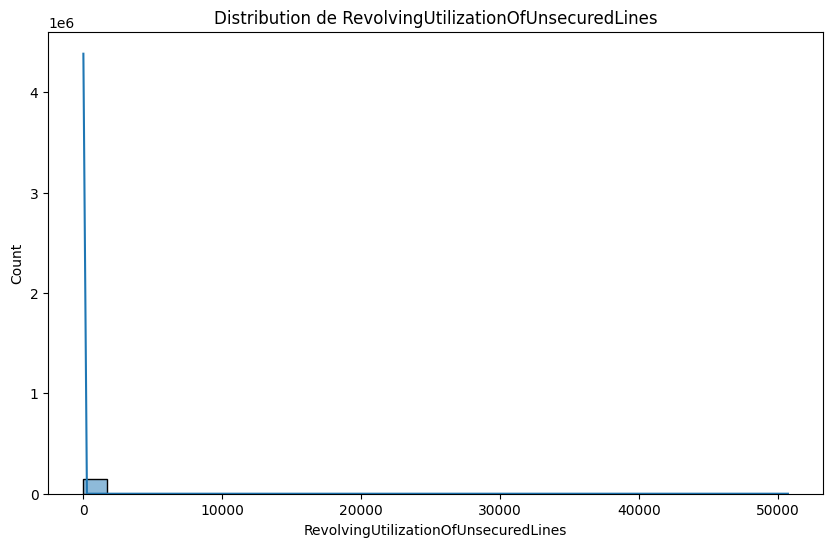

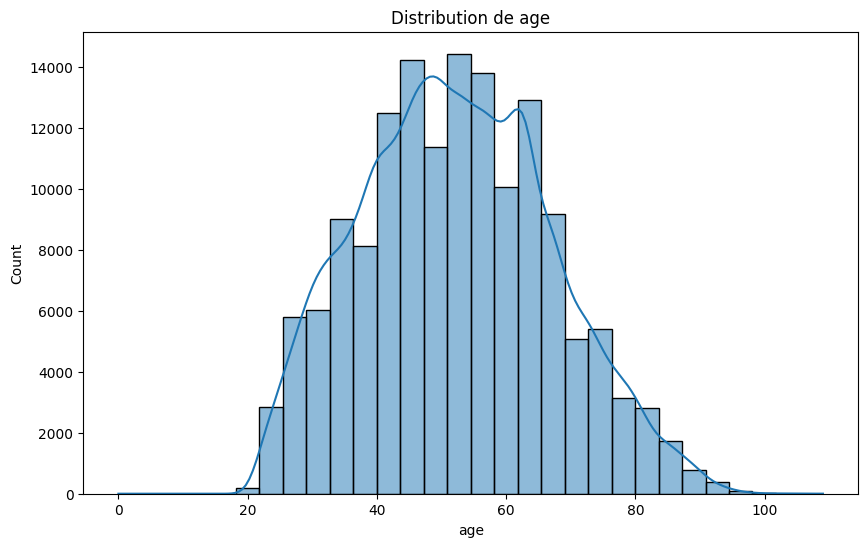

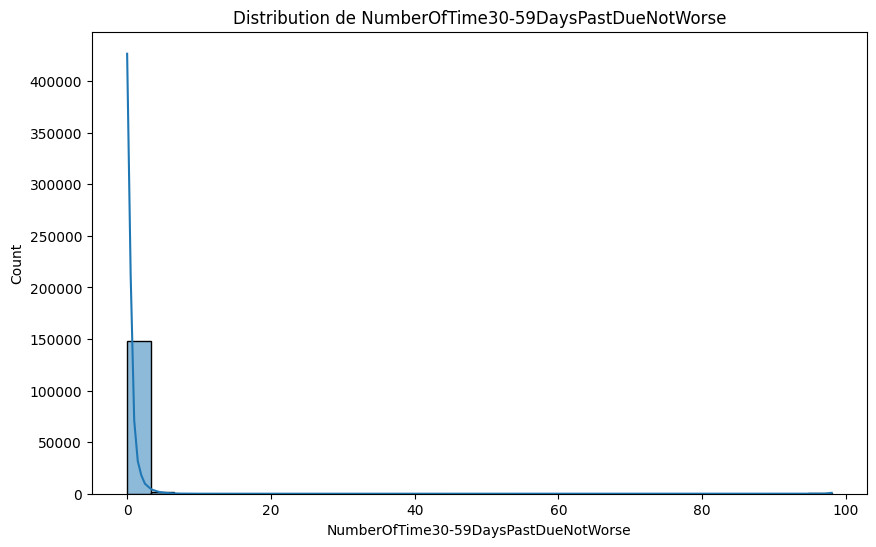

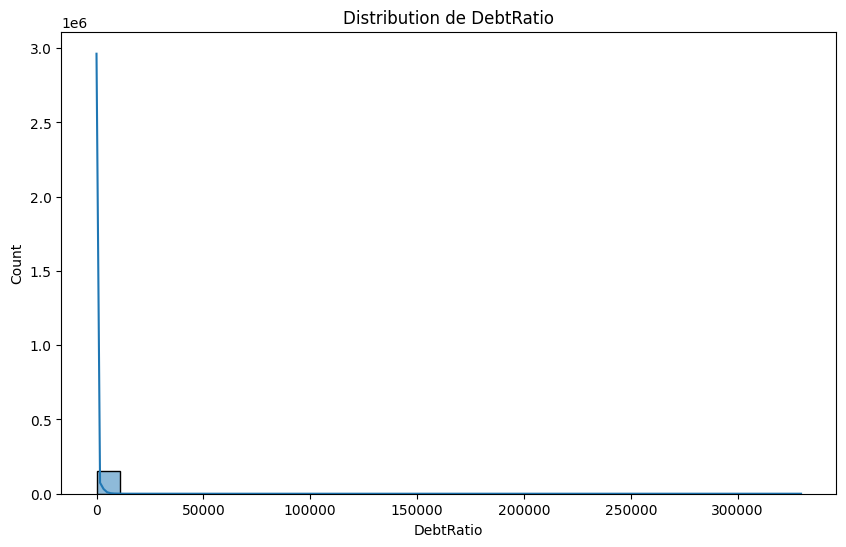

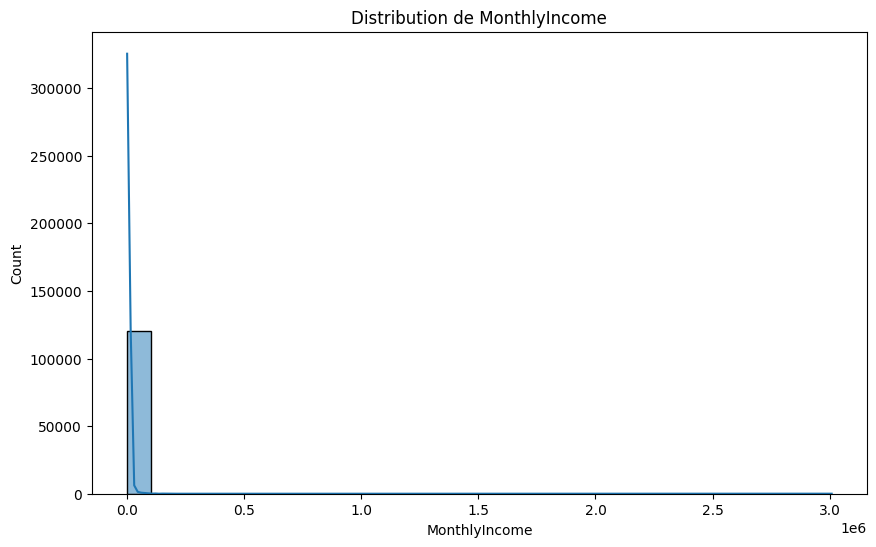

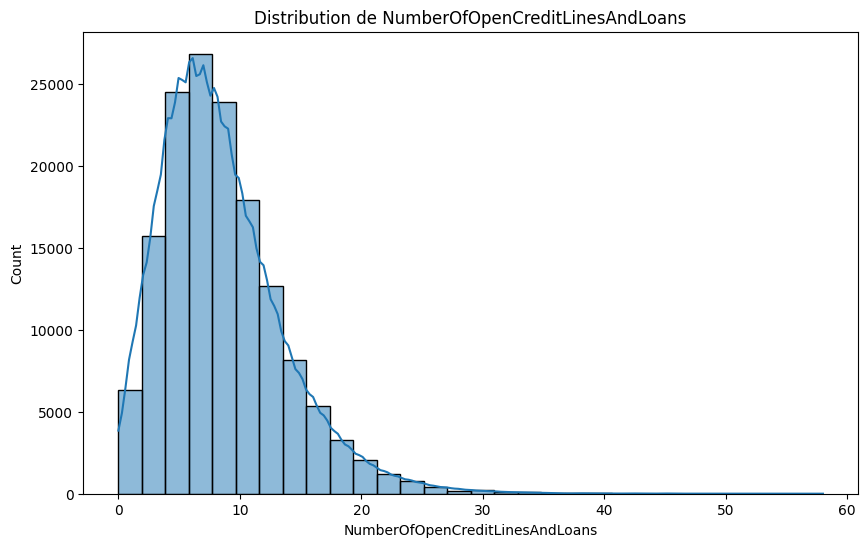

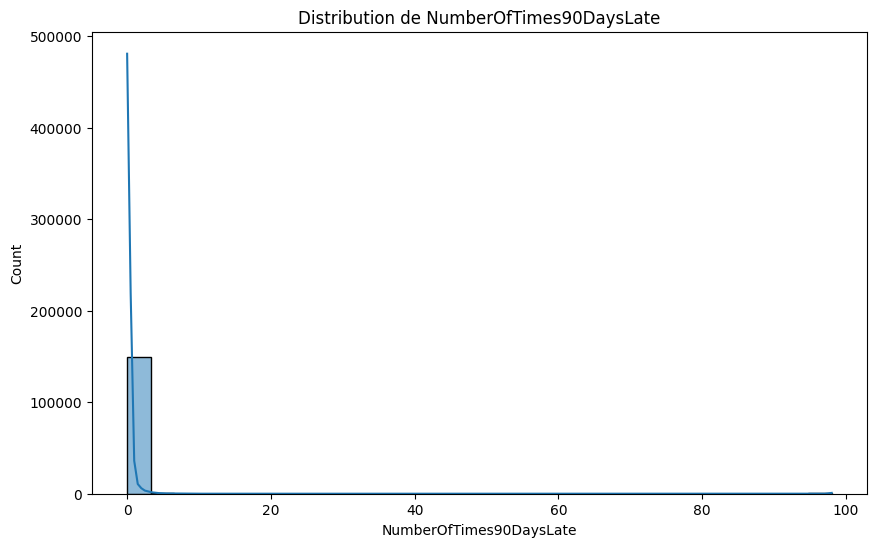

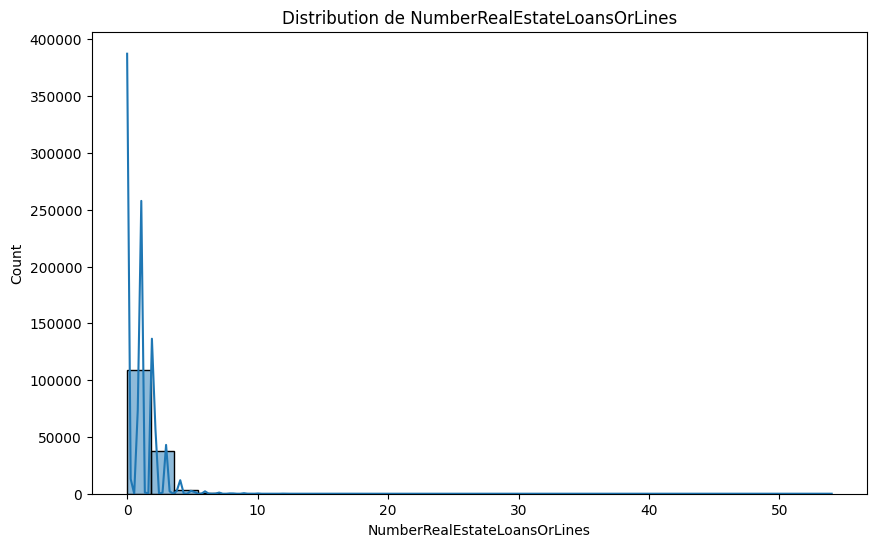

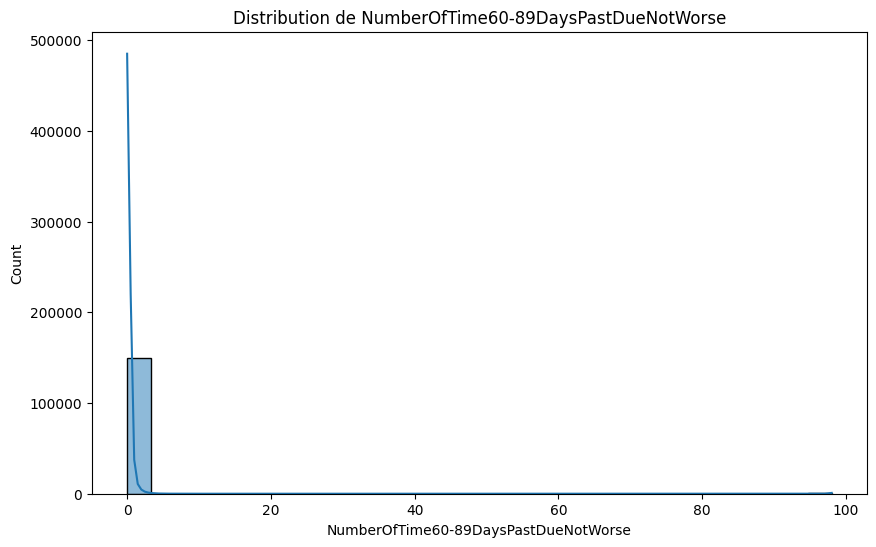

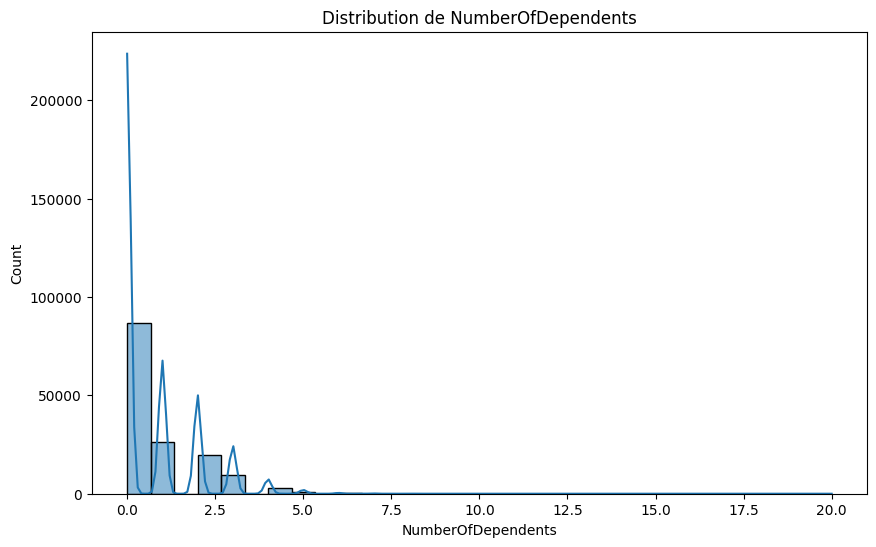


Valeurs manquantes après imputation :
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Données après nettoyage et normalisation :
       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     146679.000000                          1.466790e+05  146679.000000   
mean           0.059920                         -2.991779e-16      52.481766   
std            0.237339                          1.000003e+00      14.763178   
min            0.000000                         -8.990530e-01       0.000000   
25%            0.000000                   

<ipython-input-1-0ef8423bd02d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


Données enrichies avec nouvelles caractéristiques sauvegardées.
Meilleurs paramètres pour Random Forest : {'max_depth': 10, 'n_estimators': 200}
Meilleurs paramètres pour Gradient Boosting : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Rapport de classification pour Random Forest :
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27541
           1       0.57      0.11      0.18      1795

    accuracy                           0.94     29336
   macro avg       0.76      0.55      0.58     29336
weighted avg       0.92      0.94      0.92     29336


ROC-AUC pour Random Forest : 0.853800719899094

Rapport de classification pour Gradient Boosting :
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27541
           1       0.53      0.14      0.23      1795

    accuracy                           0.94     29336
   macro avg       0.74      0.57      0.60     29336
we

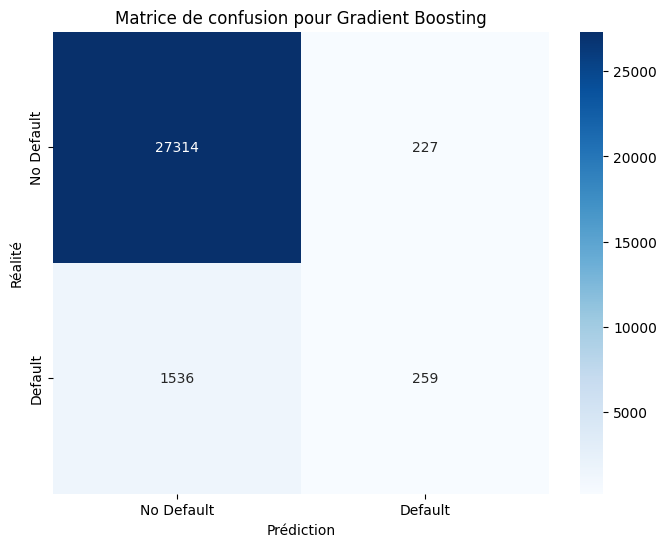

Matrice de confusion pour Gradient Boosting :
 [[27314   227]
 [ 1536   259]]


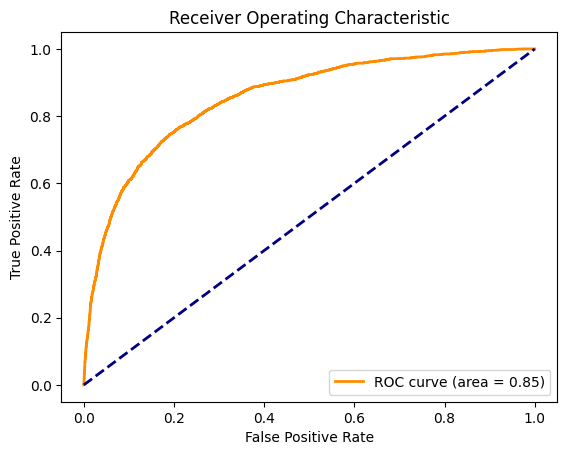

Meilleurs paramètres après ablation : {'max_depth': 10, 'n_estimators': 200}

Rapport de classification après ablation :
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27541
           1       0.57      0.11      0.19      1795

    accuracy                           0.94     29336
   macro avg       0.76      0.55      0.58     29336
weighted avg       0.92      0.94      0.92     29336


ROC-AUC après ablation : 0.8527993867638615


In [ ]:
import pandas as pd
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

# Téléchargement du dataset depuis Kaggle
path = kagglehub.dataset_download("brycecf/give-me-some-credit-dataset")
print("Path to dataset files:", path)
data_path = f"{path}/cs-training.csv"
data = pd.read_csv(data_path)

# 1. Description des données
print("Aperçu des données :")
print(data.head())
print("\nStatistiques descriptives :")
print(data.describe())
print("\nValeurs manquantes :")
print(data.isnull().sum())

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

for col in data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.show()

# 2. Nettoyage des données
data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
imputer = SimpleImputer(strategy="median")
data['MonthlyIncome'] = imputer.fit_transform(data[['MonthlyIncome']])
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(0)
print("\nValeurs manquantes après imputation :")
print(data.isnull().sum())
data = data[data['RevolvingUtilizationOfUnsecuredLines'] <= 1]

scaler = StandardScaler()
numerical_cols = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
print("\nDonnées après nettoyage et normalisation :")
print(data.describe())

# 3. Ingénierie des caractéristiques
data['IncomePerDependent'] = data['MonthlyIncome'] / (data['NumberOfDependents'] + 1)
print("\nDonnées après ajout de nouvelles caractéristiques :")
print(data.head())
data.to_csv("engineered_data.csv", index=False)
print("Données enrichies avec nouvelles caractéristiques sauvegardées.")

# 4. Sélection des modèles
data = pd.read_csv("engineered_data.csv")
X = data.drop(['SeriousDlqin2yrs'], axis=1)
y = data['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Random Forest
model_rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_estimator_
print("Meilleurs paramètres pour Random Forest :", grid_search_rf.best_params_)

# Modèle Gradient Boosting
model_gbm = GradientBoostingClassifier(random_state=42)
param_grid_gbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_gbm = GridSearchCV(model_gbm, param_grid_gbm, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_gbm.fit(X_train, y_train)
best_model_gbm = grid_search_gbm.best_estimator_
print("Meilleurs paramètres pour Gradient Boosting :", grid_search_gbm.best_params_)

# 5. Évaluation des deux modèles
# Random Forest
y_pred_rf = best_model_rf.predict(X_test)
y_pred_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]
print("\nRapport de classification pour Random Forest :")
print(classification_report(y_test, y_pred_rf))
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("\nROC-AUC pour Random Forest :", roc_auc_rf)

# Gradient Boosting
y_pred_gbm = best_model_gbm.predict(X_test)
y_pred_proba_gbm = best_model_gbm.predict_proba(X_test)[:, 1]
print("\nRapport de classification pour Gradient Boosting :")
print(classification_report(y_test, y_pred_gbm))
roc_auc_gbm = roc_auc_score(y_test, y_pred_proba_gbm)
print("\nROC-AUC pour Gradient Boosting :", roc_auc_gbm)

# Matrice de confusion pour Gradient Boosting
cm_gbm = confusion_matrix(y_test, y_pred_gbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Matrice de confusion pour Gradient Boosting')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()
print("Matrice de confusion pour Gradient Boosting :\n", cm_gbm)

# Courbe ROC pour Gradient Boosting
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, y_pred_proba_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)
plt.figure()
plt.plot(fpr_gbm, tpr_gbm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gbm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 5bis. Étude d'ablation : suppression de la caractéristique `IncomePerDependent`
X_ablation = X.drop(columns=['IncomePerDependent'])
X_train_ablation, X_test_ablation, y_train_ablation, y_test_ablation = train_test_split(X_ablation, y, test_size=0.2, random_state=42)

model_ablation = RandomForestClassifier(random_state=42)
param_grid_ablation = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
grid_search_ablation = GridSearchCV(model_ablation, param_grid_ablation, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_ablation.fit(X_train_ablation, y_train_ablation)
best_model_ablation = grid_search_ablation.best_estimator_
print("Meilleurs paramètres après ablation :", grid_search_ablation.best_params_)

y_pred_ablation = best_model_ablation.predict(X_test_ablation)
y_pred_proba_ablation = best_model_ablation.predict_proba(X_test_ablation)[:, 1]
print("\nRapport de classification après ablation :")
print(classification_report(y_test_ablation, y_pred_ablation))
roc_auc_ablation = roc_auc_score(y_test_ablation, y_pred_proba_ablation)
print("\nROC-AUC après ablation :", roc_auc_ablation)
